<a href="https://colab.research.google.com/github/Satwikram/Extending-Existing-Tf-model-with-more-classes/blob/main/Extending_Existing_Tf_model_with_more_class.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Author: Satwik Ram K
### Adding Classes to existing Tensorflow model


### Connecting to Kaggle

In [ ]:
from google.colab import files

files.upload()


! mkdir ~/.kaggle


! cp kaggle.json ~/.kaggle/

! chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [ ]:
! kaggle datasets download -d alessiocorrado99/animals10

 99% 579M/586M [00:09<00:00, 132MB/s]
100% 586M/586M [00:09<00:00, 62.6MB/s]


In [ ]:
! unzip /content/animals10.zip

### Importing Librarries

In [7]:
import numpy as np #Linear Algebra
import matplotlib.pyplot as plt
import cv2
import os
import pickle
%matplotlib inline
import pandas as pd
from tqdm import tqdm_notebook as tqdm
import tensorflow as tf

In [8]:
img_size = (64, 64) #Setting all the images to 150 pixels

### Defining the function to get data

In [9]:
classes = []

In [10]:
def get_data(data_dir):
  data = []
  count = 0
  print(os.path.basename(data_dir))
  folder = os.path.basename(data_dir)
  classes.append(folder)
  index = classes.index(folder)
  print(index)
  print(folder)
  for img in os.listdir(data_dir):
    if count == 1500:
      break
    else:
      try:
        image_array = cv2.imread(os.path.join(data_dir, img), cv2.IMREAD_COLOR)
        resized_array = cv2.resize(image_array, img_size)
        data.append([resized_array, index])
        count += 1

      except Exception as e:
        print(e)

  print("Collected",count+1,"no of images")
  return data

In [11]:
data = get_data('/content/raw-img/cane')

cane
0
cane
Collected 1501 no of images


In [12]:
classes

['cane']

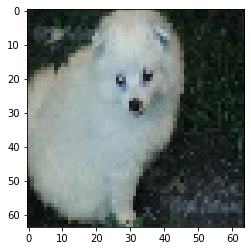

In [13]:
plt.imshow(data[2][0])


In [14]:
data1 = get_data('/content/raw-img/cavallo')

cavallo
1
cavallo
Collected 1501 no of images


In [15]:
classes

['cane', 'cavallo']

Text(0.5, 1.0, '1')

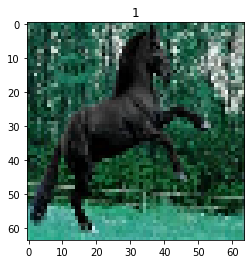

In [16]:
plt.imshow(data1[2][0])
plt.title(data1[2][1])

In [17]:
data2 = get_data('/content/raw-img/elefante')

elefante
2
elefante
Collected 1447 no of images


### Combining the data

In [18]:
dataset = data + data1 + data2

In [19]:
print(dataset[1000][1])
print(dataset[2000][1])
print(dataset[3000][1])

0
1
2


### Taking X and Y

In [20]:
X = []
y = []

In [21]:
for i in range(len(dataset)):
  X.append(dataset[i][0])
  y.append(dataset[i][1])

In [22]:
print(len(X))
print(len(y))

4446
4446


### Normalizing the Data

In [23]:
X = np.array(X)
y = np.array(y)

In [24]:
y[997]

0

In [25]:
type(y[0])

numpy.int64

In [26]:
X = X / 255.0

### Splitting the data

In [27]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 388)


In [28]:
X_train[0].shape

(64, 64, 3)

In [29]:
print(len(X_train))
print(len(y_train))

3556
3556


In [30]:
classes

['cane', 'cavallo', 'elefante']

In [31]:
y_train

array([1, 1, 2, ..., 1, 2, 0])

In [32]:
y_train = tf.keras.utils.to_categorical(y_train, 3)
y_test = tf.keras.utils.to_categorical(y_test, 3)

In [33]:
y_train

array([[0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       ...,
       [0., 1., 0.],
       [0., 0., 1.],
       [1., 0., 0.]], dtype=float32)

### Building the model

In [34]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten, Activation

In [35]:
def build_model():
  model = Sequential()

  model.add(Conv2D(filters = 64, kernel_size = (3,3), input_shape = X_train[0].shape, padding = 'same'))
  model.add(Activation('relu'))
  model.add(MaxPooling2D((2,2)))

  model.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'same'))
  model.add(Activation('relu'))
  model.add(MaxPooling2D((2,2)))
  model.add(Dropout(0.5))

  model.add(Conv2D(256, (3,3), padding = 'same'))
  model.add(Activation('relu'))
  model.add(MaxPooling2D((2,2)))
  model.add(Dropout(0.5))

  model.add(Flatten())
  model.add(Dense(512))
  model.add(Activation('relu'))
  model.add(Dropout(0.5))
  model.add(Dense(3))
  model.add(Activation('softmax'))

  return model

In [36]:
model = build_model()

In [37]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 64)        1792      
_________________________________________________________________
activation (Activation)      (None, 64, 64, 64)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 128)       73856     
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 128)       0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 128)       0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 128)       0

### Creating Checkpoints and Callbacks

In [38]:
from tensorflow.keras.optimizers import SGD, RMSprop
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

In [39]:
checkpoint = ModelCheckpoint("animals.h5",
                             monitor="val_loss",
                             mode="min",
                             save_best_only = True,
                             verbose=1)

In [40]:
earlystop = EarlyStopping(monitor = 'val_loss', 
                          min_delta = 0, 
                          patience = 3,
                          verbose = 1,
                          restore_best_weights = True)

In [41]:
reduce_lr = ReduceLROnPlateau(monitor = 'val_loss',
                              factor = 0.2,
                              patience = 3,
                              verbose = 1,
                              min_delta = 0.0001)

In [42]:
# we put our call backs into a callback list/
callbacks = [earlystop, checkpoint, reduce_lr]

### Compiling the model

In [43]:
# We use a very small learning rate 
model.compile(loss = 'categorical_crossentropy',
              optimizer = RMSprop(lr = 0.001),
              metrics = ['accuracy'])

### Training the model

In [44]:
model.fit(X_train, y_train, epochs = 10, validation_split = 0.1, callbacks = callbacks)

Epoch 1/10
100/100 [==============================] - ETA: 0s - loss: 1.1718 - accuracy: 0.4272
Epoch 00001: val_loss improved from inf to 1.00495, saving model to animals.h5
100/100 [==============================] - 81s 810ms/step - loss: 1.1718 - accuracy: 0.4272 - val_loss: 1.0050 - val_accuracy: 0.5506
Epoch 2/10
100/100 [==============================] - ETA: 0s - loss: 0.9443 - accuracy: 0.5684
Epoch 00002: val_loss improved from 1.00495 to 0.88819, saving model to animals.h5
100/100 [==============================] - 82s 821ms/step - loss: 0.9443 - accuracy: 0.5684 - val_loss: 0.8882 - val_accuracy: 0.6208
Epoch 3/10
100/100 [==============================] - ETA: 0s - loss: 0.8634 - accuracy: 0.6244
Epoch 00003: val_loss improved from 0.88819 to 0.77153, saving model to animals.h5
100/100 [==============================] - 82s 823ms/step - loss: 0.8634 - accuracy: 0.6244 - val_loss: 0.7715 - val_accuracy: 0.6966
Epoch 4/10
100/100 [==============================] - ETA: 0s - l

In [45]:
model.evaluate(X_test, y_test)

28/28 [==============================] - 5s 185ms/step - loss: 0.5774 - accuracy: 0.7865


[0.5773521065711975, 0.7865168452262878]

### Loading the saved model

In [46]:
from tensorflow.keras.models import load_model

In [47]:
loaded_model = load_model('/content/animals.h5')

In [48]:
loaded_model.outputs

[<tf.Tensor 'activation_4/Softmax_1:0' shape=(None, 3) dtype=float32>]

### Single Prediction

In [58]:
img = cv2.imread('/content/raw-img/elefante/OIP-u7Oik3NkqlDj_yiHvOOnqQHaD-.jpeg', cv2.IMREAD_COLOR)

In [59]:
img.shape

(161, 300, 3)

In [60]:
img = cv2.resize(img, img_size)

In [61]:
from tensorflow.keras.preprocessing import image

In [62]:
img.shape

(64, 64, 3)

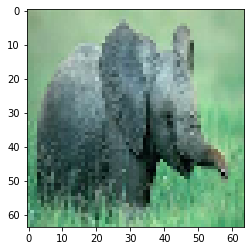

In [63]:
plt.imshow(img)

In [64]:
img = image.img_to_array(img)
img = np.expand_dims(img, axis = 0)

In [65]:
result = loaded_model.predict(img)

In [67]:
np.argmax(result)

0